# Database Operations in Python

In the previous exercise, we ran SQL queries using the `psql` client. For more complex queries and for reproducibility, queries can be automated through programming. In this exercise you will use Python to manipulate data and objects in the database. This exercise will make use of the same spatial tables (Philadelphia census tract polygons and accident points) that you loaded in the previous exercise.

This exercise makes use of `psycopg2`, a DB-API 2.0 compliant Python package for accessing PostgreSQL databases. This package is installed in the course conda environment. Python also has a built-in package `sqlite3` for working with SQLite databases. The process is very similar. In the code below you will see that we will execute SQL statements using a **cursor** and then iterate the cursor to see the results.

SQLAlchmey is another more powerful but more complex package. With `psycopg2` or other DB-API compliant packages you write SQL statements yourself, whereas with SQLAlchemy, once you learn its syntax it translates your Python commands to SQL. Since SQL dialects can differ, SQLAlchemy will translate your Python into the appropriate SQL dialect (Postgres vs. SQLite) without your having to learn a new dialect or alter your code. It is also object relational mapper (ORM), allowing you to load table rows into class instances, or create a new instance and then insert it into the table as new row.

## Section 1: Access and query the database

As in the previous exercise, we need to use the connection string values to connect to the database. These are the same parameters that we used in QGIS, DBeaver, `psql`, and `ogr2ogr`:

* Host: `localhost`
* Port: `5433`
* Database: `gis`
* User and Password: `docker`

### 1.1 Call SQL through Python and fetch the resultset

The following code demonstrates the basic recipe for database access in Python. You create a **connection** object using the connection string. You create a **cursor**, which is similar to a Python iterator. It is a collection that you can traverse to work with rows returned in the resultset. You then execute a SQL query (written as a Python string) against the cursor.

Since the resultset for this query is small, we will use the `fetchall` method to retrieve all rows at once. If the resultset were large, we might use `fetchone` or `fetchmany` to retrieve one or a specified number of rows at a time. This can be used to avoid loading a large dataset into memory and to return partial results faster.

SQL statements are often written on multiple lines for readability. Python allows you to create multi-line text strings by triple quoting the string. Note that SQL uses single quotes as a string delimiter and double quotes for object identifiers. (Double quoting identifiers is optional in most cases, but necessary if the column or table name has special characters or embedded spaces. It is usually a good idea to avoid naming objects that way!) Therefore, it is common to triple quote SQL statements in Python even when they are written on a single line:

```
sql = '''SELECT "my column" FROM "my table" WHERE "text column" = 'matching text';'''
```

In [1]:
import psycopg2
from pprint import pprint

# Create connection object, cursor object
conn = psycopg2.connect(host="localhost", port="5433", database="gis", user="docker", password="docker")
cur = conn.cursor()

# Define and execute SQL statement
select = '''SELECT state, county, tract FROM census3652;'''
cur.execute(select)

# fetch all the selected records
rows = cur.fetchall()
pprint(rows)

[('42', '101', '014500'),
 ('42', '101', '031200'),
 ('42', '101', '021800'),
 ('42', '101', '009100'),
 ('42', '101', '033600'),
 ('42', '101', '004202'),
 ('42', '101', '021300'),
 ('42', '101', '016800'),
 ('42', '101', '007000'),
 ('42', '101', '029100'),
 ('42', '101', '030000'),
 ('42', '101', '000804'),
 ('42', '101', '980100'),
 ('42', '101', '013300'),
 ('42', '101', '012204'),
 ('42', '101', '012203'),
 ('42', '101', '013602'),
 ('42', '101', '034502'),
 ('42', '101', '000902'),
 ('42', '101', '001202'),
 ('42', '101', '001201'),
 ('42', '101', '002702'),
 ('42', '101', '026301'),
 ('42', '101', '000100'),
 ('42', '101', '000200'),
 ('42', '101', '029200'),
 ('42', '101', '024400'),
 ('42', '101', '033200'),
 ('42', '101', '000300'),
 ('42', '101', '980200'),
 ('42', '101', '980500'),
 ('42', '101', '036700'),
 ('42', '101', '037800'),
 ('42', '101', '037600'),
 ('42', '101', '001001'),
 ('42', '101', '000402'),
 ('42', '101', '036900'),
 ('42', '101', '037300'),
 ('42', '101

Notice that the cursor returns the dataset as a **list** of **tuples**. The data can be accessed using normal list/tuple slicing and indexing. Unlike a pandas dataframe, there is no header row (i.e., no column names). You have to know based on your query that the first "column" is the `statefp`, etc.

Note that the cursor can be traversed *once*. If we use the `fetchall` method again, there are no more rows left to retrieve:

In [2]:
rows = cur.fetchall()
pprint(rows)

[]


The `fetchone` method can be used to return one row at a time. Each row is represented as a tuple. Since the cursor can be traversed once, if you use `fetchall` at this point, it only returns rows not yet accessed.

In [3]:
cur.execute(select)

row = cur.fetchone()
print(f"The first row is {row}.")

row = cur.fetchone()
print(f"The second row is {row}.")

rows = cur.fetchall()
print(f"There are {len(rows)} rows remaining.")

The first row is ('42', '101', '014500').
The second row is ('42', '101', '031200').
There are 382 rows remaining.


Normally we don't traverse the resultset like this. Since the cursor is an iterator, if we need to process rows one by one, we can use a while loop to iterate the cursor, do whatever we need to do, and when the last row is fetched, the loop breaks:

In [4]:
cur.execute(select)

row = cur.fetchone()
while row: # This is true as long as the cursor has fetched a row
    print(row)
    row = cur.fetchone()



('42', '101', '014500')
('42', '101', '031200')
('42', '101', '021800')
('42', '101', '009100')
('42', '101', '033600')
('42', '101', '004202')
('42', '101', '021300')
('42', '101', '016800')
('42', '101', '007000')
('42', '101', '029100')
('42', '101', '030000')
('42', '101', '000804')
('42', '101', '980100')
('42', '101', '013300')
('42', '101', '012204')
('42', '101', '012203')
('42', '101', '013602')
('42', '101', '034502')
('42', '101', '000902')
('42', '101', '001202')
('42', '101', '001201')
('42', '101', '002702')
('42', '101', '026301')
('42', '101', '000100')
('42', '101', '000200')
('42', '101', '029200')
('42', '101', '024400')
('42', '101', '033200')
('42', '101', '000300')
('42', '101', '980200')
('42', '101', '980500')
('42', '101', '036700')
('42', '101', '037800')
('42', '101', '037600')
('42', '101', '001001')
('42', '101', '000402')
('42', '101', '036900')
('42', '101', '037300')
('42', '101', '037200')
('42', '101', '038400')
('42', '101', '025600')
('42', '101', '0

If we were modifying the data with inserts, updates, or deletes, the modifications would be batched in a **transaction**. If we reuse the cursor without using `conn.commit()` to **commit** the transaction, no changes would be written to the database. For those of you familiar with desktop GIS, this is similar to turning on editing for a layer, editing the data, and then saving or abandoning the changes. In database terms this is referred to as a **commit** (save changes) or **rollback** (abandon changes).

For select queries, this is not strictly necessary. However, if there is an error in your query, the transaction is held open until it is explicitly committed. Here is an example with an intentionally borked query that we attempt to fix and rerun with issuing a commit.

In [5]:
broken_query = '''SELECT statefp, countyfp, tractce, namelsad FROM nonexistent_table;'''
cur.execute(broken_query)

# fetch all the selected records
rows = cur.fetchall()
print(f"{len(rows)} rows fetched.")

UndefinedTable: relation "nonexistent_table" does not exist
LINE 1: SELECT statefp, countyfp, tractce, namelsad FROM nonexistent...
                                                         ^


Now we attempt to use the correct query string defined in the `select` variable. It still doesn't work.

In [6]:
cur.execute(select)

# fetch all the selected records
rows = cur.fetchall()
print(f"{len(rows)} rows fetched.")

InFailedSqlTransaction: current transaction is aborted, commands ignored until end of transaction block


If we use `conn.commit()` to close the last transaction, we can run the correct query.

In [8]:
conn.commit()
cur.execute(select)

# fetch all the selected records
rows = cur.fetchall()
print(f"{len(rows)} rows fetched.")

384 rows fetched.


### 1.2 Count the number of point in each census tract

We will repeat the point-in-polygon spatial query you executed in `psql` in the last exercise.

This query does a spatial join of the points and census tract polygons, groups the matching rows by census tract, and counts the number of rows in each group (census tract). We define the SQL statement and execute it using the database cursor. We use the SQL string concatenation operator (`||`) to get an 11-digit tract identifier. `GROUP BY 1` allows us to group on the first column of the resultset without having to repeat the expression.

In [9]:
sql = '''SELECT c.statefp || c.countyfp || c.tractce, count(*) as num
        FROM philadata3652 p JOIN census3652 c ON ST_Intersects(c.geom, p.geom)
        GROUP BY 1;'''

cur.execute(sql)

rows = cur.fetchall()
for row in rows:
    print(f"Census Tract {row[0]} contains {row[1]} points.")
    

Census Tract 42101000402 contains 70 points.
Census Tract 42101003702 contains 86 points.
Census Tract 42101015600 contains 114 points.
Census Tract 42101035200 contains 203 points.
Census Tract 42101031000 contains 200 points.
Census Tract 42101008601 contains 57 points.
Census Tract 42101019502 contains 96 points.
Census Tract 42101016200 contains 107 points.
Census Tract 42101000100 contains 123 points.
Census Tract 42101000803 contains 36 points.
Census Tract 42101035800 contains 182 points.
Census Tract 42101021800 contains 99 points.
Census Tract 42101008802 contains 82 points.
Census Tract 42101019700 contains 112 points.
Census Tract 42101006300 contains 118 points.
Census Tract 42101010900 contains 95 points.
Census Tract 42101020300 contains 127 points.
Census Tract 42101980300 contains 297 points.
Census Tract 42101036303 contains 214 points.
Census Tract 42101036202 contains 95 points.
Census Tract 42101020700 contains 328 points.
Census Tract 42101033200 contains 66 points

We can use the `WHERE` clause (line 3 of the query string) to limit the results to 2014.

In [5]:
sql = """SELECT c.tractce, count(p.panoid) as num
         FROM philadata3652 p JOIN census3652 c ON ST_Intersects(c.geom, p.geom)
         WHERE p.year = '2014'
         GROUP BY c.tractce;"""

cur.execute(sql)

rows = cur.fetchall()
for row in rows:
    print(f"Census Tract {row[0]} contained {row[1]} points in 2014.")


UndefinedColumn: column c.tractce does not exist
LINE 1: SELECT c.tractce, count(p.panoid) as num
               ^
HINT:  Perhaps you meant to reference the column "c.tract".


### 1.3 Save the result into a spatial file

As in Exercise 3, we can save the results of this query to a spatial layer on disk (specifically, we will save to the GeoPackage format).

Although we still have an open connection, we will reimport all modules and recreate the connection and cursor so that this cell contains a fully worked example. We being by closing the old connection. (This cleanup workup is usually not necessary, but you should know how to do it. It may be necessary for more complex analyses.)

In [6]:
del(cur)
conn.close()
print(f"The connection is closed: {bool(conn.closed)}")
del(conn)

The connection is closed: True


In order to export a spatial layer, we need to retrieve the geometry from the database. In PostGIS, the geometry column is just another column that can be returned by the query. By convention, PostGIS developers will name this geometry column `geom`. Following this convention will save you from having to check the table definition to figure out which column is the geometry column or what its name is.

In the SQL statement we group by `c.gid`, which is the primary key (unique identifier) for the census tract table. *Because we are grouping on the table's primary key, we do not have to include other census tract columns in the `GROUP BY` clause!* We are implicitly grouping on the `tractce`, `countyfp`, etc.

The `loads` method in the `shapely.wkb` module will load a Well Known Binary (WKB) geometry into a shapely geometry. PostGIS stores geometries internally in a modified WKB format.

In [8]:
# Fix needed for issues with PROJ library not setting necessary environment variable
import os
import pyproj
os.environ['PROJ_LIB'] = pyproj.datadir.get_data_dir()
# Do we need to set os.environ['GDAL_DATA'] also???

from shapely.geometry import Point, mapping
import psycopg2
import fiona
from shapely.wkb import loads

conn = psycopg2.connect(host="localhost", port="5433", database="gis", user="docker", password="docker")
cur = conn.cursor()

sql = """SELECT c.tract, c.county, c.state, count(*), c.geom
         FROM philadata3652 p JOIN census3652 c ON ST_Intersects(c.geom, p.geom)
         GROUP BY c.id;"""

cur.execute(sql)


# prepare the schema and crs of the output layer
schema = {
    'geometry': 'MultiPolygon',
    'properties': {
        'tractce': 'str: 20',
        'countyfp': 'str: 20',
        'count': 'int'
    }
}

crs = {'init': u'epsg:3652'}


# Write the resultset to a GeoPackage using fiona
with fiona.open("output/test.gpkg", "w", driver = "GPKG", crs = crs, schema=schema) as output:
    rows = cur.fetchall()
    for row in rows:
        print("The tractce, countyfp, statefp, and number points are: ", row[0], row[1], row[3])
        tractce = row[0]
        countyfp = row[1]
        count = row[2]
        
        geom = loads(row[-1], hex = True) # <- Create usable shapely geometry from WKT
        
        output.write({'properties':{'tractce': tractce,
                                    'countyfp': countyfp,
                                    'count': count
                                    },
                      'geometry': mapping(geom)
                     })
        
print ("\nYou have successfully exported the results to a GeoPackage.")


The tractce, countyfp, statefp, and number points are:  014500 101 42
The tractce, countyfp, statefp, and number points are:  031200 101 156
The tractce, countyfp, statefp, and number points are:  021800 101 99
The tractce, countyfp, statefp, and number points are:  009100 101 106
The tractce, countyfp, statefp, and number points are:  033600 101 249
The tractce, countyfp, statefp, and number points are:  004202 101 142
The tractce, countyfp, statefp, and number points are:  016800 101 156
The tractce, countyfp, statefp, and number points are:  007000 101 64
The tractce, countyfp, statefp, and number points are:  029100 101 180
The tractce, countyfp, statefp, and number points are:  980100 101 139
The tractce, countyfp, statefp, and number points are:  021300 101 112
The tractce, countyfp, statefp, and number points are:  030000 101 213
The tractce, countyfp, statefp, and number points are:  013300 101 95
The tractce, countyfp, statefp, and number points are:  012204 101 98
The tractce

The tractce, countyfp, statefp, and number points are:  017601 101 150
The tractce, countyfp, statefp, and number points are:  024700 101 150
The tractce, countyfp, statefp, and number points are:  024900 101 88
The tractce, countyfp, statefp, and number points are:  025200 101 205
The tractce, countyfp, statefp, and number points are:  025400 101 176
The tractce, countyfp, statefp, and number points are:  035200 101 203
The tractce, countyfp, statefp, and number points are:  980300 101 297
The tractce, countyfp, statefp, and number points are:  035500 101 370
The tractce, countyfp, statefp, and number points are:  035800 101 182
The tractce, countyfp, statefp, and number points are:  035900 101 286
The tractce, countyfp, statefp, and number points are:  036000 101 151
The tractce, countyfp, statefp, and number points are:  036100 101 185
The tractce, countyfp, statefp, and number points are:  026000 101 81
The tractce, countyfp, statefp, and number points are:  027500 101 106
The trac

The tractce, countyfp, statefp, and number points are:  030200 101 191
The tractce, countyfp, statefp, and number points are:  030600 101 196
The tractce, countyfp, statefp, and number points are:  036301 101 298
The tractce, countyfp, statefp, and number points are:  036302 101 157
The tractce, countyfp, statefp, and number points are:  036303 101 214
The tractce, countyfp, statefp, and number points are:  036400 101 236
The tractce, countyfp, statefp, and number points are:  030700 101 101
The tractce, countyfp, statefp, and number points are:  030800 101 174
The tractce, countyfp, statefp, and number points are:  030900 101 104
The tractce, countyfp, statefp, and number points are:  031000 101 200
The tractce, countyfp, statefp, and number points are:  031300 101 193
The tractce, countyfp, statefp, and number points are:  031600 101 102
The tractce, countyfp, statefp, and number points are:  031700 101 172
The tractce, countyfp, statefp, and number points are:  031800 101 132
The tr

## Section 2 Create database tables using Python

In section 1 we used Python to query and fetch data from an existing table (the table that we imported into the database in Lab 5). Now, we are going to use Python to read the original data file and create tables programmatically.


### 2.1 Create a spatial point layer using Python

We begin with a `CREATE TABLE` statement. The `IF NOT EXISTS` clause will prevent an error from being thrown if the table already exists.

We use standard PostGIS conventions such as:

* Using `snake_case` for table and column names;
* Using `gid` as the name of the primary key column;
* Using `geom` as the name of the geometry column;
* The geometry column must be **typemodded** with the vector type (POINT, LINESTRING, POLYGON, and MULTI* versions of each) and SRID.

When we are creating database objects and modifying data, `conn.commit()` is *necessary*. Without, your database changes will be lost if you delete or reuse the cursor.

In [9]:
create_point_table = """
    CREATE TABLE IF NOT EXISTS panostreet (
        gid int GENERATED ALWAYS AS IDENTITY PRIMARY KEY,
        panoid varchar NOT NULL,
        year varchar NOT NULL,
        month varchar NOT NULL,
        pano_yaw real NOT NULL,
        gvi real,
        geom geometry(Point, 3652)
    );
    """

cur.execute(create_point_table)
conn.commit()

### 2.2 Insert records into the point layer

Inserts are accomplished with the `INSERT` statement. In the following code, we use Fiona to open the point layer, extract certain columns, and insert each feature (with its attributes) to the database table.

*This method will be far slower than the import tools demonstrated previously!* It is demonstrated here because it is useful as part of an extract-transform-load (ETL) process, common to big data analysis. That is, it is useful when rather than loading an entire dataset as is, you need to somehow modify (transform) the source data as you load it into the database.

In the following code we use Shapely to access the Well Known Text (WKT) representation of each geometry, and then use the PostGIS function `ST_GeometryFromText` to convert it into PostGIS' native geometry representation.

In [10]:
from shapely.geometry import shape

pntShp = "data/philadata3652.gpkg"
pntLyr = fiona.open(pntShp)
for featPnt in pntLyr:
    # get the attributes of the feature
    props = featPnt['properties']
    panoid = props['PANOID']
    year = props['YEAR']
    month = props['MONTH']
    pano_yaw = props['PANO_YAW']
    gvi = props['GVI']
    
    # get the geometry of features in WKT format
    geom_wkt = shape(featPnt['geometry']).wkt
    
    insert_point_feature = f"""
        INSERT INTO panostreet (panoid, year, month, pano_yaw, gvi, geom) 
        VALUES('{panoid}', '{year}', '{month}', {pano_yaw}, {gvi}, 
            ST_GeometryFromText('{geom_wkt}', 3652)
            )
        ;"""
    cur.execute(insert_point_feature)  
    
conn.commit()


Let's investigate the final insert statement that we executed with all substituted values.

In [11]:
print(insert_point_feature)


        INSERT INTO panostreet (panoid, year, month, pano_yaw, gvi, geom) 
        VALUES('mtm4QTzANaqakehlfXS3_A', '2011', '07', 193.0, 8.198, 
            ST_GeometryFromText('POINT (2693998.9220890934 242209.58790727254)', 3652)
            )
        ;


### 2.3 Create a spatial polygon layer using Python

The `CREATE TABLE` for the polygon layer should look familiar.

Note that we set the polygon type to be MultiPolygon. PostGIS is strict about datatypes, and inserting a MultiPolygon into a Polygon column, or vice versa, will throw an error. We don't know for certain that the Census Tract layer has any MultiPolygons, but MultiPolygons are so common (think about states like Hawaii) that it is usually best to assume that MultiPolygons will be present.

In [12]:
create_polygon_table = """
    CREATE TABLE IF NOT EXISTS cttable (
        gid int GENERATED ALWAYS AS IDENTITY PRIMARY KEY,    
        statefp varchar NOT NULL,
        tractce varchar NOT NULL,
        geom geometry(MultiPolygon, 3652)
    );
    """

cur.execute(create_polygon_table)
conn.commit()


### 2.4 Insert records into the polygon layer


In [13]:
conn.commit()
censusShp = "data/census3652.gpkg"
censusLyr = fiona.open(censusShp)
for feat in censusLyr:
    # get the attributes of the feature
    props = feat['properties']
    statefp = props['STATEFP']
    tractce = props['TRACTCE']
    
    # get the geometry of features in WKT format
    geom = shape(feat['geometry']).wkt
    
    insert_polygon_features = f"""
        INSERT INTO cttable (statefp, tractce, geom) 
        VALUES('{statefp}', '{tractce}', 
            ST_GeometryFromText('{geom}', 3652)
            )
        ;"""
    cur.execute(insert_polygon_features)  
    
conn.commit()


## 3. Access PostGIS Layer Using Geopandas

GeoPandas can load PostGIS spatial layers directly using `gpd.read_postgis`. Using GeoPandas is convenient because you can then use GeoPandas plotting.

You need to pass in (or create) a database connection object to do this. Although you will receive a warning that Pandas only support SQLAlchemy connections, `gpd.read_postgis` nonetheless works with a psycopg2 connection.

In [14]:
import geopandas as gpd

sql = "SELECT * FROM census3652;"
gdf = gpd.read_postgis(sql, conn)

/home/lukemckinstry/anaconda3/envs/geospatial4/lib/python3.11/site-packages/geopandas/io/sql.py:185: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(
/home/lukemckinstry/anaconda3/envs/geospatial4/lib/python3.11/site-packages/geopandas/io/sql.py:473: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(spatial_ref_sys_sql, con)


You can then plot the geodataframe using methods we have shown previously.

/tmp/ipykernel_220938/3610639676.py:3: FutureWarning: GeoDataFrame.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  gdf.replace(to_replace=-666666666, inplace=True )


<Axes: >

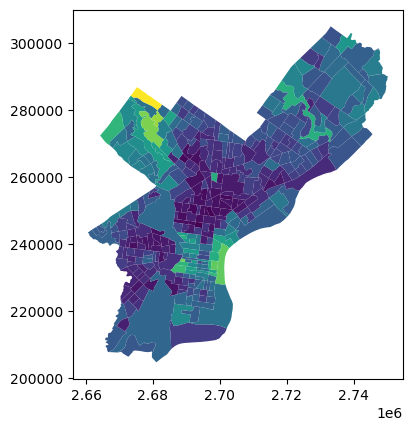

In [15]:
# Fix data type and replace suppressed value -666666666
gdf["median_hou"] = gdf["median_hou"].astype(int)
gdf.replace(to_replace=-666666666, inplace=True )

# Create a basic choropleth map with no customization
gdf.plot(column = "median_hou")

## Homework:

Replicate your Lab 2 analysis using Python. As with Lab 2, construct a filter of your choosing to restrict the traffic accident points to a particular time period (year and month).

1. Use QGIS to load crash_data_collision_crash_2007_2017.gpkg into your database. Make sure to transform the coordinates to 3652 to match the existing `census3652` layer in the database.
2. Construct a query to count the number of accident points in each Census tract. Use the `WHERE` clause to restrict the accidents to a particular year and month.
3. Load the query results into a geodataframe. You can do this in one of two ways:
    a. Use psycopg2 to return a cursor; use Fiona to save the results to a GeoPackage; use GeoPandas to load the geopackage.
    b. Construct the geodataframe by passing the query string directly to the `gpd.read_postgis` method.
4. Use the geodataframe to create a choropleth map of the accident count by census tract.

Upload your Jupyter Notebook file to Canvas. 